In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Read datasets and labels

In [2]:
df = pd.read_csv("../1_Attack dataset/Local Area Network/data/attack_dataset.csv") # attack dataset
attack_classes = pd.read_csv("../1_Attack dataset/Local Area Network/data/attack_labels_sbseg.csv") # labels
bonafide = pd.read_csv('../2_Bonafide dataset/data/bonafide_dataset_20191121.csv.gz') # bonafide dataset
print(df.shape, bonafide.shape)

(86480, 41) (103094, 41)


### Attack labels

In [3]:
attack_classes['label'].unique()

array(['nmap_tcp_syn', 'nmap_tcp_conn', 'nmap_tcp_null', 'nmap_tcp_xmas',
       'nmap_tcp_fin', 'nmap_tcp_ack', 'nmap_tcp_window',
       'nmap_tcp_maimon', 'unicornscan_tcp_syn', 'unicornscan_tcp_conn',
       'unicornscan_tcp_null', 'unicornscan_tcp_xmas',
       'unicornscan_tcp_fxmas', 'unicornscan_tcp_fin',
       'unicornscan_tcp_ack', 'hping_tcp_syn', 'hping_tcp_null',
       'hping_tcp_xmas', 'hping_tcp_fin', 'hping_tcp_ack', 'zmap_tcp_syn',
       'masscan_tcp_syn'], dtype=object)

In [4]:
attack_classes['label'] = 'attack'

### Create **attack dataset** with labels defined by  *ip_src*

In [5]:
df_labeled = df.merge(attack_classes, how='inner', left_on='ip.src', right_on='ip')
df_labeled.drop(['ip'], axis=1, inplace=True)
df_labeled.head(2)

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Dec 31, 1969 21:03:41.953641000 -03",221.953641,20,58,58,0x00000800,4,20,NaN,0x0000b2c5,0x00000000,0,0,0,0,46,6,0x000019e0,172.16.0.3,10.10.10.10,44,0x00000000,62218,8888,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00005cb1,0,1460.0,attack
1,1,"Dec 31, 1969 21:03:41.953762000 -03",221.953762,21,58,58,0x00000800,4,20,NaN,0x0000d3a4,0x00000000,0,0,0,0,37,6,0x00000201,172.16.0.3,10.10.10.10,44,0x00000000,62218,587,0,0,0,24,0x00000002,0,1,0,0,0,0,0,1024,0x00007d1e,0,1460.0,attack


In [6]:
bonafide['label'] = "bonafide" # create column label on bonafide dataset

## Comparing _bonafide_ and _attack_ datasets
> Check if both dataset have the same columns/features/attributes and calculate the balance (%) of bonafide and attack packets

In [7]:
if (df_labeled.columns == bonafide.columns).all():
    examples_attack = df_labeled.shape[0]
    examples_bonafide = bonafide.shape[0]
    total = examples_attack+examples_bonafide
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_attack/total, examples_bonafide/total))

Total examples of 125467 with 0.18 of attack and 0.82 bonafide packets


## Pre-processing
> Required to convert features that were extracted from `pcap` as hexadecimal
> Filled the values with NaN with Zero

In [8]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df_labeled[field] = df_labeled[field].apply(lambda x: int(str(x), 16))
    

In [9]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create AB-TRAP dataset with all packets (bonafide and attack)

In [10]:
full_data = pd.concat([bonafide, df_labeled])

### Check if there are packets with the protocol field different than TCP (value 6)

In [11]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("It was found and removed", wrong_proto,"packets.")

It was found and removed [11708] packets.


### Features not applicable to this study

> Remove features from link layer - layer 2:
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove features that are redundant or invariable
> - ip.version - we consider only IPv4
> - ip.proto - this study is applicable only to TCP
> - ip.src - this attribute is removed to allow the generalization of learning (not learn past attackers)
> - ip.dst - this attribute is removed to allow the generalization of learning (not learn past targets)
> - ip.flags - this is removed because we use bit-set of flags
> - tcp.flags - this is removed because we use bit-set of flags

In [12]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [13]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113759 entries, 1 to 22372
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           113759 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                113759 non-null  int64  
 3   ip.flags.rb          113759 non-null  float64
 4   ip.flags.df          113759 non-null  float64
 5   ip.flags.mf          113759 non-null  float64
 6   ip.frag_offset       113759 non-null  float64
 7   ip.ttl               113759 non-null  float64
 8   ip.checksum          113759 non-null  int64  
 9   ip.len               113759 non-null  float64
 10  ip.dsfield           113759 non-null  int64  
 11  tcp.srcport          113759 non-null  float64
 12  tcp.dstport          113759 non-null  float64
 13  tcp.seq              113759 non-null  float64
 14  tcp.ack              113759 non-null  float64
 15  tcp.len           

In [14]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,113759.0,91386.0,113759.000000,113759.0,113759.000000,113759.0,113759.0,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,1.137590e+05,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,113759.000000,1.137590e+05,113759.000000,113759.000000,100484.000000
mean,20.0,0.0,31347.585993,0.0,0.618316,0.0,0.0,125.907691,32187.994005,629.721332,2.249668,25553.705491,28784.728971,4.012405e+07,4.092436e+07,582.295388,27.425944,0.077137,0.308705,0.022407,0.094683,0.619046,0.035417,0.009608,8.807325e+03,32342.675208,0.766427,198.943693
std,0.0,0.0,19694.286820,0.0,0.485802,0.0,0.0,87.436633,19038.950443,690.759214,8.171465,25107.425855,24827.699185,1.113061e+08,2.439186e+08,688.715939,7.659989,0.266809,0.461961,0.148004,0.292777,0.485624,0.184832,0.097549,7.951332e+04,19024.617715,182.598351,512.382545
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,1.000000,40.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,13956.000000,0.0,0.000000,0.0,0.0,59.000000,15260.500000,40.000000,0.000000,443.000000,993.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.290000e+02,15978.000000,0.000000,0.000000
50%,20.0,0.0,31071.000000,0.0,1.000000,0.0,0.0,62.000000,31861.000000,64.000000,0.000000,20166.000000,35008.000000,1.000000e+00,1.000000e+00,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.070000e+02,32081.000000,0.000000,0.000000
75%,20.0,0.0,48841.500000,0.0,1.000000,0.0,0.0,242.000000,48728.500000,1426.000000,0.000000,51351.000000,51436.000000,1.367624e+07,4.610000e+03,1374.000000,32.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.200000e+03,48581.500000,0.000000,0.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,0.0,254.000000,65534.000000,5981.000000,224.000000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,5941.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65533.000000,46335.000000,8961.000000


In [15]:
# check features with zero variance (not useful for learning)
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [16]:
# remove columns with zero variance
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [17]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

In [18]:
_columns = 3
lines = int(full_data.shape[1]/_columns)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(lines, _columns, i)
        full_data.boxplot([column]);
        i += 1

### Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

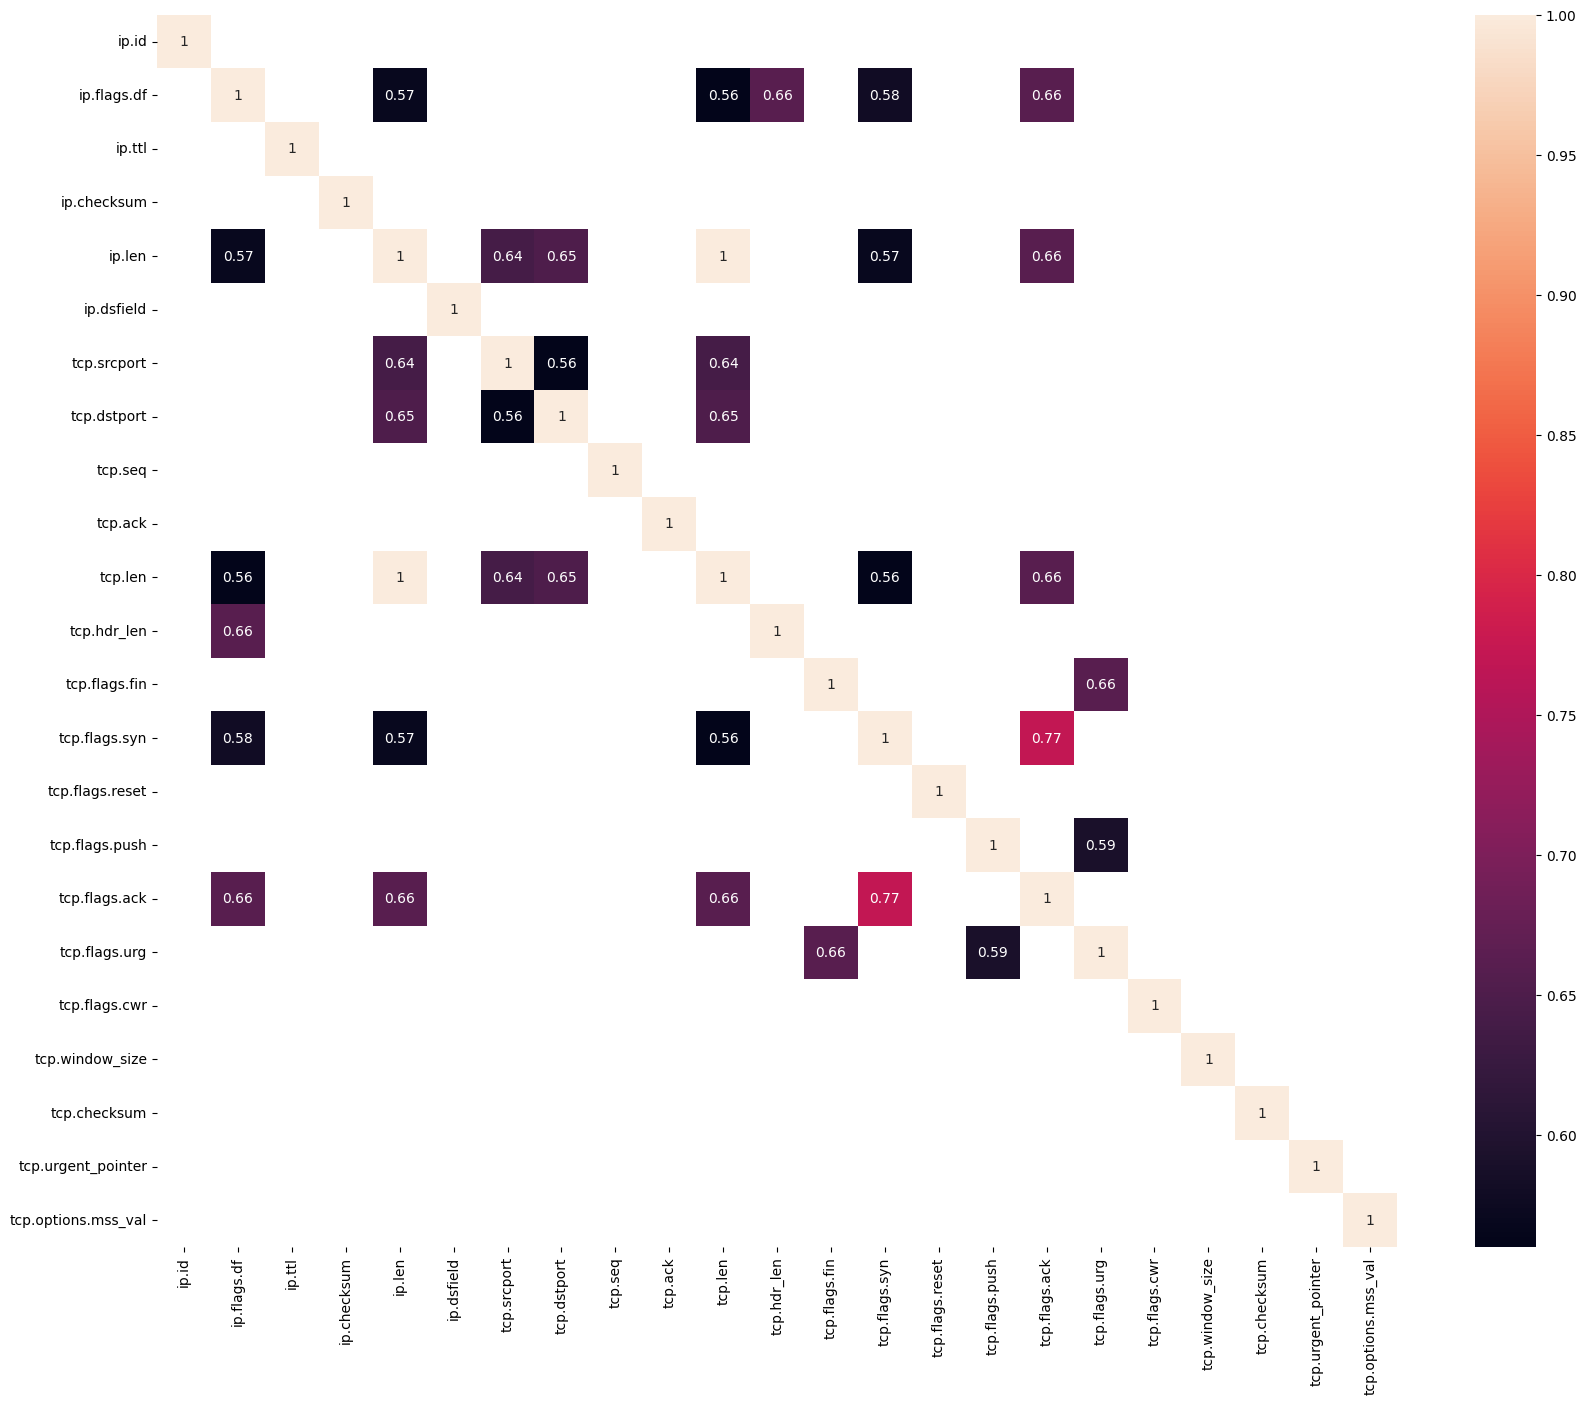

In [19]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

## Machine Learning - Binary Classification _(attack x bonafide)_

In [20]:
full_data['label'].value_counts()

bonafide    91386
attack      22373
Name: label, dtype: int64

In [21]:
full_data.label[full_data.label == "bonafide"] = 0 # convert bonafide label to 0
full_data.label[full_data.label != 0] = 1 # convert attack labels to 1
full_data['label'].value_counts()

0    91386
1    22373
Name: label, dtype: int64

In [22]:
full_data.shape

(113759, 24)

In [23]:
# It is removed ttl because previous attempt shows that it is learning the LAN architecture TTL=62
# (from scan tools TTL=64 minus 2 routers in the infrastructure)

# sequence, checksum and acknowledge features because they are random

# removed source and destination ports to be agnostic regarding the service ports

# removed tcp.options.mss_val because it is dificult to be retrieved as LKM

full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [24]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22368,32904,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1
22369,55978,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,1
22370,32903,0.0,40.0,0,0.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1200.0,0.0,1
22371,6985,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,1


In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    "NB" : (GaussianNB(), {}),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(113759, 15) (113759,)


In [26]:
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0


In [27]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0,40,0,0,20,0,1,0,0,0,0,0,1024,0
3,3793,1,537,8,485,32,0,0,0,1,1,0,0,252,0
4,0,1,80,0,0,60,0,0,0,0,1,0,0,4677,0
5,8559,1,54,0,2,32,0,0,0,1,1,0,0,115,0
6,54321,0,40,8,0,20,0,1,0,0,0,0,0,65535,0


## Grid Search

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB


In [29]:
# f1-scores
pd.DataFrame.from_dict(score)

,NB
0,0.547546
1,0.542172
2,0.553234
3,0.553465
4,0.548419
5,0.547078
6,0.547747
7,0.549361
8,0.547590
9,0.539101


## ROC/AUC evaluation

In [30]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = roc_auc_score

results = {}
for algorithm in algorithms.keys():
    results[algorithm] = { 'expected': [], 'predicted': [] }

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])).transpose()[1])

NB


In [31]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    auc = roc_auc_score(results[algorithm]['expected'], results[algorithm]['predicted'])
    print('AUC(%s) = %.4f' % (algorithm, auc))

AUC(NB) = 0.8798


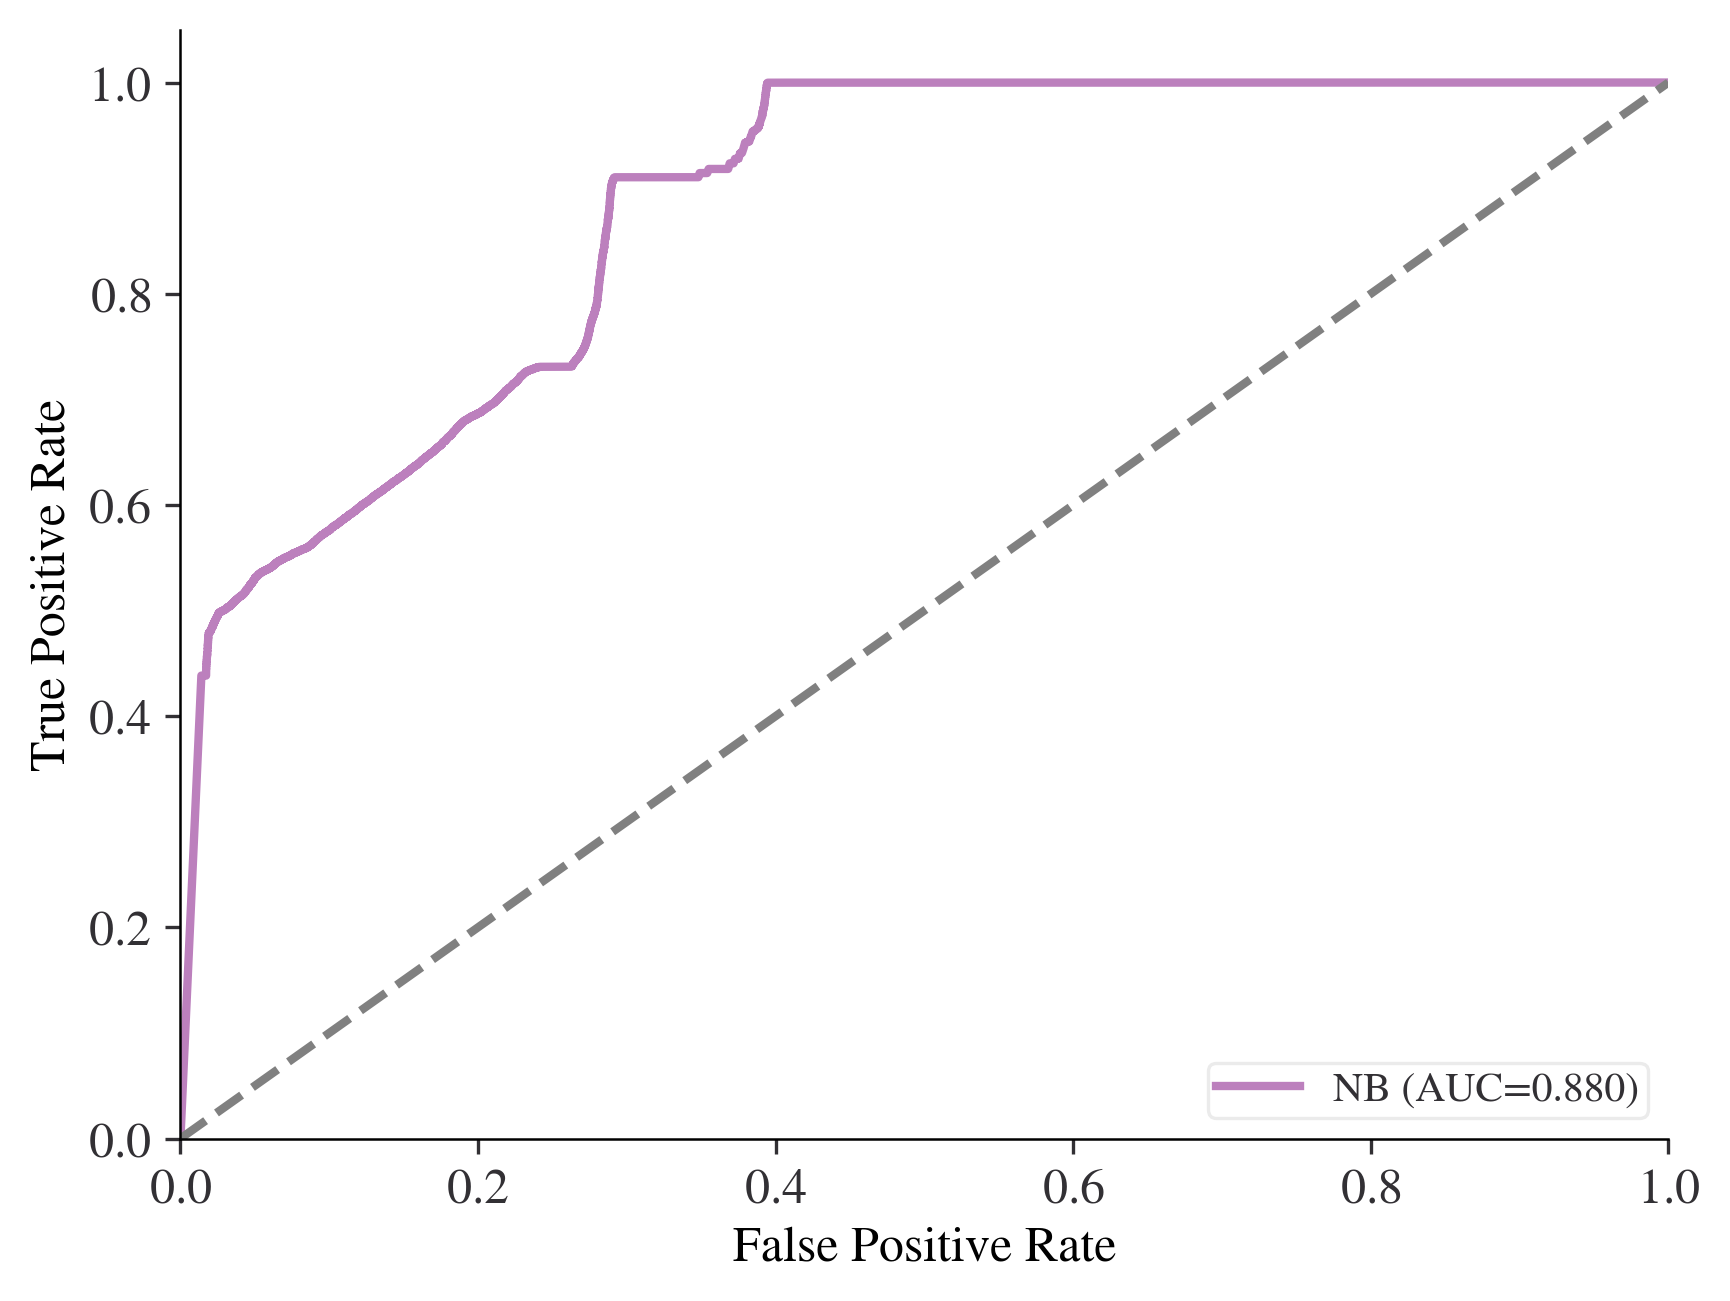

In [32]:
import os
from sklearn.metrics import roc_curve, auc

plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = roc_curve(result['expected'], result['predicted'])
    AUC = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label="{} (AUC={:.3f})".format(model_key, AUC))
    index = index + 1
    # save ROC data
    filename = 'data/LAN_'+model_key+'_ROC_data.csv'
    pd.DataFrame.from_dict(data={ 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds }).to_csv(filename, index=False)
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), dpi=300, bbox_inches="tight")

In [33]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import pickle
from enum import Enum

class Action(Enum):
    TRAIN = "Train"
    TEST = "Test"

In [34]:
def print_results(action: Action, scores, accuracy, confusion_matrix, classification):
    print()
    print('--------------------------- {} Results --------------------------------\n', action.value)
    print("Cross Validation Mean Score: {} \n", scores.mean())
    print()
    print("Model Accuracy: {} \n", accuracy)
    print()
    print("Confusion matrix: {} \n", confusion_matrix)
    print()
    print("Classification report: {} \n", classification)
    print()

In [35]:
bayes = GaussianNB()
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=0)

bayes.fit(X_train, Y_train)
train_predict_X = bayes.predict(X_train)
train_scores = cross_val_score(bayes, X_train, Y_train, cv=5)
train_accuracy = metrics.accuracy_score(Y_train, train_predict_X)
train_confusion_matrix = metrics.confusion_matrix(Y_train, train_predict_X)
train_classification = metrics.classification_report(Y_train, train_predict_X)

print_results(Action.TRAIN, train_scores, train_accuracy, train_confusion_matrix, train_classification)

test_predict_X = bayes.predict(X_test)
test_scores = cross_val_score(bayes, X_test, Y_test, cv=7)
test_accuracy = metrics.accuracy_score(Y_test, test_predict_X)
test_confusion_matrix = metrics.confusion_matrix(Y_test, test_predict_X)
test_classification = metrics.classification_report(Y_test, test_predict_X)

print_results(Action.TEST, test_scores, test_accuracy, test_confusion_matrix, test_classification)

filename = '../../model/bayes_model.sav'
pickle.dump(bayes, open(filename, 'wb'))


--------------------------- {} Results --------------------------------
 Train
Cross Validation Mean Score: {} 
 0.652283719025381

Model Accuracy: {} 
 0.6522836583742513

Confusion matrix: {} 
 [[36283 27689]
 [    0 15659]]

Classification report: {} 
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     63972
           1       0.36      1.00      0.53     15659

    accuracy                           0.65     79631
   macro avg       0.68      0.78      0.63     79631
weighted avg       0.87      0.65      0.69     79631



--------------------------- {} Results --------------------------------
 Test
Cross Validation Mean Score: {} 
 0.6607180689149516

Model Accuracy: {} 
 0.64943741209564

Confusion matrix: {} 
 [[15453 11961]
 [    3  6711]]

Classification report: {} 
               precision    recall  f1-score   support

           0       1.00      0.56      0.72     27414
           1       0.36      1.00      0.53      67